<a href="https://colab.research.google.com/github/fjme95/calculo-optimizacion/blob/main/Semana%207/Fourier_Neural_Operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Repositorio original: https://github.com/zongyi-li/fourier_neural_operator

Publicación: https://arxiv.org/pdf/2010.08895.pdf

Las imágenes se extrajeron de la publicación

# Archivo: Adam.py

Implementación de del optimizador adam

In [1]:
%%writefile Adam.py

import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss


Writing Adam.py


# Archivo: utilities3.py

Varias utilidades: 
- Lector de archivos .mat
- Funciones de pérdida
- Normalizadores

In [2]:
%%writefile utilities3.py

import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial

#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c


Writing utilities3.py


# Dependencias

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""


import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

# Capa de Fourier

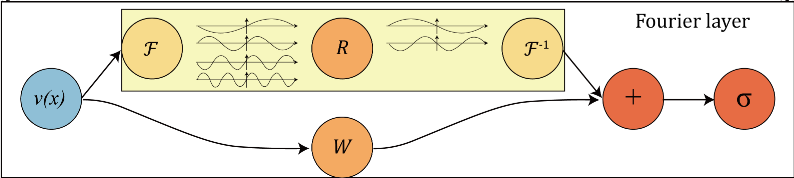

Se comienza desde la entrada v. 

Arriba: aplica la transformada de Fourier; una transformación lineal R en los modos de Fourier bajos y se filtran los modos altos; luego se aplica la inversa de la transformada de Fourier.

Abajo: Se aplica una transformación lineal W.


In [3]:
class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


# Operador Neural de Fourier



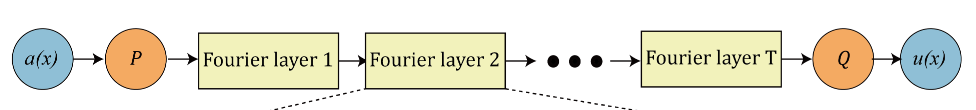

Comienza desde la entrada a. 

1. Aumenta la dimensión del espacio del canal usando una red neuronal P.
2. Aplica 4 capas de operadores integrales (transformada de fourier) y funciones de activación.
3. Proyecta a la dimensión objetivo con una red neuronal Q.
4. La salida es u

In [ ]:

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(12, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/MyDrive/datasets/NavierStokes_V1e-5_N1200_T20.zip

Archive:  /content/gdrive/MyDrive/datasets/NavierStokes_V1e-5_N1200_T20.zip
  inflating: NavierStokes_V1e-5_N1200_T20.mat  


In [15]:
!unzip /content/gdrive/MyDrive/datasets/NavierStokes_V1e-4_N20_T50_R256_test.zip

Archive:  /content/gdrive/MyDrive/datasets/NavierStokes_V1e-4_N20_T50_R256_test.zip
  inflating: ns_data_V1e-4_N20_T50_R256test.mat  


In [6]:
################################################################
# configs
################################################################

TRAIN_PATH = '/content/NavierStokes_V1e-5_N1200_T20.mat'

ntrain = 1200

modes = 12
width = 20

batch_size = 20

epochs = 60
learning_rate = 0.01
scheduler_step = 15
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

sub = 1
S = 64
T_in = 10
T = 10
step = 1

################################################################
# load data
################################################################

reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

print(train_u.shape)

assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S,S,T_in)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)


################################################################
# training and evaluation
################################################################

model = FNO2d(modes, modes, width).cuda()

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t2 = default_timer()
    scheduler.step()
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain)



60 0.01 15 0.5
torch.Size([1200, 64, 64, 10])
926517
0 7.799948041999983 0.4575154889424642 0.4909636644522349
1 6.811958549999986 0.266673165957133 0.303790363073349
2 8.612264369000002 0.24293889490763348 0.27830160975456236
3 6.629224610999984 0.22255853430430092 0.256880601644516
4 6.815256003000002 0.20752274258931477 0.23990263879299165
5 6.604872808999971 0.1997562313079834 0.2319870169957479
6 6.617862013000035 0.1907777099609375 0.222688081463178
7 6.871235948999981 0.18153729391098022 0.21191563467184701
8 6.8840766030000395 0.1759897780418396 0.20566376984119417
9 6.624882974000002 0.18466719150543215 0.2174442434310913
10 8.288296288999959 0.17964083385467527 0.21074206372102103
11 6.584942527999999 0.17134494717915855 0.2025342478354772
12 7.092421061999971 0.16697937933603924 0.19672024269898733
13 6.648731615000031 0.16003755855560303 0.18896126588185627
14 6.673737463000009 0.15971490987141929 0.18911451975504556
15 6.6380858470000135 0.14330186637242634 0.1681532847881

# Resultados

In [11]:
for xx, yy in train_loader:
    xx = xx.to(device)
    res = model(xx)
    print(res.shape)
    break

torch.Size([20, 64, 64, 1])


In [12]:
yy.shape

torch.Size([20, 64, 64, 10])

In [13]:
#@title Ground Truth 

import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, batch_size):
    fig.add_trace(
        go.Heatmap(
            visible=False,
            z=yy[step, :, :, 0].cpu().detach().numpy()))
fig['layout']['yaxis']['scaleanchor']='x'

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

In [14]:
#@title Resultado de la red
 
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, batch_size):
    fig.add_trace(
        go.Heatmap(
            visible=False,
            z=res[step, :, :, 0].cpu().detach().numpy()))

# Make 10th trace visible
fig.data[10].visible = True
fig['layout']['yaxis']['scaleanchor']='x'

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(i)}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Frequency: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

In [20]:
################################################################
# configs
################################################################

TRAIN_PATH = '/content/NavierStokes_V1e-5_N1200_T20.mat'
TEST_PATH = '/content/ns_data_V1e-4_N20_T50_R256test.mat'

ntrain = 1200
ntest = 20

modes = 12
width = 20

batch_size = 20
batch_size2 = batch_size

epochs = 30
learning_rate = 0.01
scheduler_step = 10
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'ns_fourier_2d_rnn_V10000_T20_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

sub = 1
S = 64
T_in = 10
T = 10
step = 1

################################################################
# load data
################################################################

reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S,S,T_in)
test_a = test_a.reshape(ntest,256,256,T_in)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)


################################################################
# training and evaluation
################################################################

model = FNO2d(modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()
    scheduler.step()
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)
# torch.save(model, path_model)





30 0.01 10 0.5
torch.Size([1200, 64, 64, 10])
torch.Size([20, 256, 256, 10])
926517
0 7.678470184000162 0.6634513537089031 0.6971245698134104 1.2462718200683593 1.3800053596496582
1 7.516241218000232 0.27142669041951495 0.30736494382222496 0.9139701843261718 1.0434778213500977
2 7.531639339000321 0.24279971853892007 0.2793172903855642 0.989969482421875 1.1457143783569337
3 7.480909567999788 0.21575416564941405 0.24910651048024496 0.8019408416748046 0.924751091003418
4 7.537313627000003 0.20853658294677735 0.24245491107304892 0.8664884185791015 1.0043100357055663
5 7.5266919609998695 0.20337451839447024 0.2371216587225596 0.8454529571533204 0.9825536727905273
6 7.509004469000047 0.19658403078715006 0.22968043704827626 0.7832901000976562 0.9042612075805664
7 7.475885481000205 0.1836154826482137 0.21430323243141175 0.7692559814453125 0.8911865234375
8 7.515242925999701 0.18136298656463623 0.21249124904473624 0.7759222412109376 0.8972103118896484
9 7.513999741000134 0.17667149782180785 0.2

In [22]:
for xx, yy in test_loader:
    xx = xx.to(device)
    res = model(xx)
    print(res.shape)
    break

torch.Size([1, 256, 256, 1])


In [32]:
import plotly.express as px
px.imshow(res[0, :, :, 0].cpu().detach().numpy())

In [41]:
px.imshow(yy[0, :, :, 0].cpu().detach().numpy())

In [37]:
yy.shape

torch.Size([1, 256, 256, 10])